In [8]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
import sys
import pandas as pd
import seaborn as sns
import xarray as xr

sys.path.append('/Users/sr2/opt/anaconda3/envs/nipr_env/')
from esn_dts_openloop import ESN, Tikhonov

In [9]:
model = pickle.load(open('SMRAI2_current_SR.pkl', 'rb'))
#model = pickle.load(open('modelw099_300.sav', 'rb'))

In [10]:
# Define the function to predict on dummy data
def predict_on_dummy_data(model, By_values, n_values):
    # Initialize an array to store predictions
    all_predictions = []

    # Loop through all combinations of By and density values
    for By in By_values:
        for density in n_values:
            # Generate the input data for prediction
            Bz = 0  #nT
            v_sw = 400  #m/s
            tilt = 0  #degrees
            X_test = np.array([[By, Bz, v_sw, density, tilt]])

            # Predict
            pred = model.predict(X_test)

            # Store the prediction
            all_predictions.append(pred)

    # Convert the list of predictions to a numpy array
    all_predictions = np.array(all_predictions)

    # Reshape the predictions array to match the shape of By_values and Density_values
    all_predictions = all_predictions.reshape((len(By_values), len(n_values), -1))

    return all_predictions

# Define values for By and Density
By_values = np.arange(-10, 11, 1)
n_values = np.arange(0, 42, 1)

# Predict using the dummy data
predictions = predict_on_dummy_data(model, By_values, n_values)
predictions.shape

(21, 42, 2400)

In [11]:
pred_4d = predictions.reshape(21, -1, 30, 80)
#take first 40 from 4th dimension
#pred_nightside = pred_4d[:,:,:,20:81]
#pred_dayside = pred_4d[:,:,:,0:81]


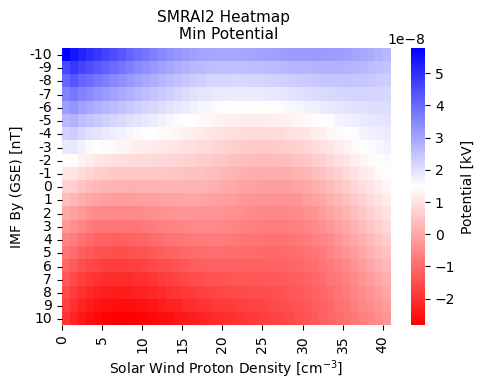

In [12]:
mean_pred = pred_4d.mean(axis=3) 
mean_pred = mean_pred.mean(axis=2)
mean_pred = mean_pred[:,1:] #first column is buggy

#flip the y axis
#mean_pred = np.flip(mean_pred, axis=0)

#plot as contour plot
plt.figure(figsize=(5, 4))
#sns.set_style("whitegrid")
#sns.heatmap(mean_pred, cmap='coolwarm', center=0, annot=False, fmt=".0f", cbar_kws={'label': 'Potential [Kv]'})
sns.heatmap(mean_pred, cmap='bwr_r', annot=False, fmt=".0f", cbar_kws={'label': 'Potential [kV]'})
#plt.colorbar(contour)
plt.xticks(ticks=np.arange(0, len(n_values), 5), labels=n_values[::5])
#plt.xticks(ticks=[0,5, 10, 15, 20, 25, 30, 35,40], labels=["< 1", 5, 10, 15, 20, 25, 30, 35,40], va="center")

cm = r'cm$^{-3}$'
plt.xlabel(f'Solar Wind Proton Density [{cm}]')

plt.yticks(ticks=np.arange(0, len(By_values), 1)+0.55, labels=By_values[::1], va="center")
#plt.gca().invert_yaxis()
plt.ylabel('IMF By (GSE) [nT]')

plt.title('SMRAI2 Heatmap \n Min Potential', fontsize=11)
#change colourbar label
plt.tight_layout()
#plt.savefig('/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/potential/param_surveys/SMRAI2_param-survey_potential-min.png', dpi=300)



In [207]:
# Define the function to predict on dummy data
def predict_convection(model, Bz_values):
    all_predictions = []

    # Loop through a definied combination of Bz or By
    for Bz in Bz_values:
        # Generate the input data for prediction
        By = 0  #nT
        v_sw = 400  #m/s
        density = 10 #cm^-3
        tilt = 0  #degrees
        X_test = np.array([[By, Bz, v_sw, density, tilt]])

        # Predict
        pred = model.predict(X_test)

        # Store the prediction
        all_predictions.append(pred)

    # Convert the list of predictions to a numpy array
    all_predictions = np.array(all_predictions)
    all_predictions = all_predictions.reshape( -1, 30, 80)
    #multiple all predictions by 1e-3
    all_predictions = all_predictions*1e6

    return all_predictions

# Define values for By and Density
Bz_values = np.arange(-10, 11, 1)
#Bz_values = np.linspace(-10, 10, 20)

# Predict using the dummy data
predictions = predict_convection(model, Bz_values)
predictions.shape

(21, 30, 80)

In [216]:
#loop through 1st dimension and plot on radar where 2nd dim is r, and 3rd dim is theta

t_pad = 15

theta = np.linspace(0, 360, 80) - 90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(53.1, 90, 30)

levels = np.linspace(-0.4, 0.4+0.001, 100) #current for By, Bz

for i in range(0, len(Bz_values)):
#for i in range(1):
    fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5.5, 4.5))
    #sns.set_style("whitegrid")

    contour=axs.contourf(theta_rad, r, predictions[i], cmap='bwr_r', levels=levels, extend='both')
    par = r'J$_{||}$'
    plt.colorbar(contour, ax=axs, label=f'Field Aligned Current ({par})  [µA/m²]', shrink=0.5, pad=0.15, 
            ticks=[-0.4, -0.2, 0, 0.2, 0.4], orientation='horizontal')

    plt.title(f'SMRAI2 \n Bz = {Bz_values[i]} nT', fontsize=11, pad=t_pad)
    axs.set_ylim([0, 30])
    axs.set_yticks([0, 10, 20, 30])
    axs.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs.set_xlim([-np.pi, np.pi])
    axs.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
    #axs.tick_params(axis='x', pad=10)
    axs.grid(True, alpha=0.7)

    #add text to top left of plot
    By = r'$\mathrm{B_y}$'
    axs.annotate(f'{By}: 0 nT', xy=(-0.2, 1.3), xycoords='axes fraction')
    vsw = r'v$_{sw}$'
    axs.annotate(f'{vsw}: 400 km/s', xy=(-0.2, 1.2), xycoords='axes fraction')
    n = r'n$_p$'
    cm = r'cm$^{-3}$'
    axs.annotate(f'{n}: 10 {cm}', xy=(-0.2, 1.1), xycoords='axes fraction')
    tilt = r'$\theta_{tilt}$'
    axs.annotate(f'{tilt}: 0°', xy=(-0.2, 1.0), xycoords='axes fraction')

    #change colourbar label
    plt.tight_layout()

    plt.savefig(f'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/current/param_surveys/Bz/{i+10}_SMRAI2_J-survey_potential_Bz.png', dpi=300, bbox_inches='tight')
    plt.close()

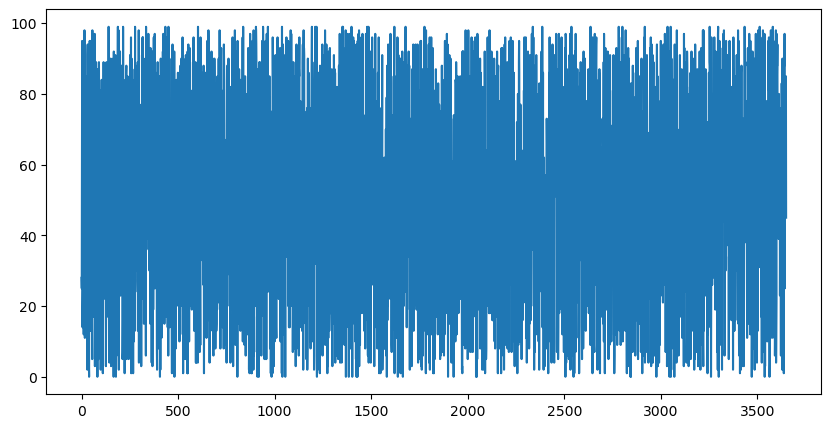

In [218]:
#download the average rainfall data for tokyo across 2000 to 2010 then plot it

#create some dummy rainfall data for 10 years

rainfall = np.random.randint(0, 100, 3650)

#plot the data
plt.figure(figsize=(10, 5))
plt.plot(rainfall)



